In [3]:
!export PYTHONPATH=$PYTHONPATH:${PWD}

In [1]:
import tensorflow as tf

# Function to print the first record from a TFRecord file
def print_first_record(tfrecord_path):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_path)
    
    # Get the first record
    for raw_record in raw_dataset.take(3000):
        # Decode the raw record
        example_proto = tf.train.Example()
        example_proto.ParseFromString(raw_record.numpy())
        
        # Print the record
        print("Parsed record:")
        for feature in example_proto.features.feature:
            value = example_proto.features.feature[feature]
            if value.HasField('int64_list'):
                print(f"{feature}: {value.int64_list.value}")
            elif value.HasField('float_list'):
                print(f"{feature}: {value.float_list.value}")
            elif value.HasField('bytes_list'):
                print(f"{feature}: {value.bytes_list.value}")
            else:
                print(f"{feature}: {value}")

# Specify the path to your TFRecord file
tfrecord_path = "/app/ibc/data/gaze/evaluation/all_concat_mse_20220630_L4c-D8_test.tfrecord"

# Call the function to print the first record
print_first_record(tfrecord_path)


2024-09-13 05:30:39.209814: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-13 05:30:39.240552: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-13 05:30:40.551403: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:5b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-13 05:30:40.555239: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA no

Parsed record:
reward: [0.0]
observation/vel_gaze_agent: [0.0, 0.0, 0.0, 0.0]
step_type: [b'\x00\x00\x00\x00']
observation/all_gaze_agent: [-0.838484525680542, 0.00632074661552906, 0.3619654178619385, 0.001591771375387907, -0.34801337122917175, -0.005374791566282511, -0.3704827129840851, 0.014229536056518555, -0.460744172334671, 0.00626029260456562, 0.5985174775123596, -0.011696603149175644, -0.838484525680542, 0.00632074661552906, 0.3619654178619385, 0.001591771375387907, -0.34801337122917175, -0.005374791566282511, -0.3704827129840851, 0.014229536056518555, -0.460744172334671, 0.00626029260456562, 0.5985174775123596, -0.011696603149175644]
discount: [1.0]
observation/pos_first_goal: [0.5138510465621948, -0.017193101346492767, 0.5138510465621948, -0.017193101346492767]
observation/fac_gaze_agent: [0.5985174775123596, -0.011696603149175644, 0.5985174775123596, -0.011696603149175644]
next_step_type: [b'\x01\x00\x00\x00']
action: [0.51385897397995, 0.0]
Parsed record:
reward: [0.0]
obser

In [65]:
def steps(start, stop, step):
    for i in range(start, stop, step):
        yield i
_steps = steps(0, 5000, 1)

In [83]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the feature description according to the structure
# feature_description = {
#     'reward': tf.io.FixedLenFeature([], tf.float32),
#     'step_type': tf.io.FixedLenFeature([], tf.string),
#     'next_step_type': tf.io.FixedLenFeature([], tf.string),
#     'discount': tf.io.FixedLenFeature([], tf.float32),
#     'action': tf.io.FixedLenFeature([2], tf.float32),  # Assuming action is a 2D array
#     'observation/vel_agent': tf.io.FixedLenFeature([2], tf.float32),  # Assuming 2D velocity
#     'observation/pos_second_goal': tf.io.FixedLenFeature([2], tf.float32),  # Assuming 2D position
#     'observation/pos_agent': tf.io.FixedLenFeature([2], tf.float32),  # Assuming 2D position
#     'observation/pos_first_goal': tf.io.FixedLenFeature([2], tf.float32)  # Assuming 2D position
# }

# # Needed for custom loader
# feature_description = {
#     'reward': tf.io.FixedLenFeature([], tf.float32),
#     'step_type': tf.io.FixedLenFeature([], tf.string),
#     'next_step_type': tf.io.FixedLenFeature([], tf.string),
#     'discount': tf.io.FixedLenFeature([], tf.float32),
#     'action': tf.io.FixedLenFeature([2], tf.float32),  # Assuming action is a 2D array
#     'observation/fac_gaze_agent': tf.io.FixedLenFeature([2], tf.float32),  # Assuming 2D velocity
#     'observation/all_gaze_agent': tf.io.FixedLenFeature([12], tf.float32),  # Assuming 2D position
#     'observation/pos_first_goal': tf.io.FixedLenFeature([2], tf.float32),  # Assuming 2D position
#     'observation/vel_gaze_agent': tf.io.FixedLenFeature([2], tf.float32),  # Assuming 2D position
# }

# Needed for custom loader
feature_description = {
    'reward': tf.io.FixedLenFeature([], tf.float32),
    'step_type': tf.io.FixedLenFeature([], tf.string),
    'next_step_type': tf.io.FixedLenFeature([], tf.string),
    'discount': tf.io.FixedLenFeature([], tf.float32),
    'action': tf.io.FixedLenFeature([2], tf.float32),  # Assuming action is a 2D array
    'observation/fac_gaze_agent': tf.io.FixedLenFeature([4], tf.float32),  # Assuming 2D velocity
    'observation/all_gaze_agent': tf.io.FixedLenFeature([24], tf.float32),  # Assuming 2D position
    'observation/pos_first_goal': tf.io.FixedLenFeature([4], tf.float32),  # Assuming 2D position
    'observation/vel_gaze_agent': tf.io.FixedLenFeature([4], tf.float32),  # Assuming 2D position
}

# feature_description = {
#     'step_type': tf.io.FixedLenFeature([], tf.int32),
#     'observation/vel_gaze_agent': tf.io.FixedLenFeature([2], tf.float32),
#     'observation/all_gaze_agent': tf.io.FixedLenFeature([12], tf.float32),
#     'observation/pos_first_goal': tf.io.FixedLenFeature([2], tf.float32),
#     'observation/fac_gaze_agent': tf.io.FixedLenFeature([2], tf.float32),
#     'action': tf.io.FixedLenFeature([2], tf.float32),
#     'next_step_type': tf.io.FixedLenFeature([], tf.int32),
#     'reward': tf.io.FixedLenFeature([], tf.float32),
#     'discount': tf.io.FixedLenFeature([], tf.float32)
# }

# Function to parse each example
def parse_example(example_proto):
    return tf.io.parse_single_example(example_proto, feature_description)

# Load the TFRecord file
# tfrecord_file = "/app/ibc/data/particle/2d_oracle_particle_0.tfrecord"
# tfrecord_file = "/app/ibc/data/gaze/evaluation/2d_L3ad5_data.tfrecord"
# tfrecord_file = "/app/ibc/data/gaze/evaluation/mse_2d_L3ad5_data.tfrecord"


tfrecord_ebm_files = [
    "/app/ibc/data/gaze/evaluation_fixed/all_concat_20220622_L2b-D4.tfrecord",
    "/app/ibc/data/gaze/evaluation_fixed/all_concat_20220623_L3c_D5.tfrecord",
    "/app/ibc/data/gaze/evaluation_fixed/all_concat_20220630_L4c-D8.tfrecord"]

tfrecord_mse_files = [
    "/app/ibc/data/gaze/evaluation_fixed/all_concat_mse_20220622_L2b-D4.tfrecord",
    "/app/ibc/data/gaze/evaluation_fixed/all_concat_mse_20220623_L3c_D5.tfrecord",
    "/app/ibc/data/gaze/evaluation_fixed/all_concat_mse_20220630_L4c-D8.tfrecord"]

csv_files = ["/app/test_set_pt_and_tf/20220622_L2b-D4_l2cs/output.csv",
                "/app/test_set_pt_and_tf/20220623_L3c_D5_l2cs/output.csv",
                "/app/test_set_pt_and_tf/20220630_L4c-D8_l2cs/output.csv"]

# results_df = pd.DataFrame(columns=['CSV_File', 'MSE_EBM_X','MSE_EBM_Y','MSE_MSE_X','MSE_MSE_Y','MSE_MSE'])
results = []

# i = next(_steps)
for i in range(len(tfrecord_ebm_files)):
    csv_file = csv_files[i]

    x_coords_ebm, x_coords_mse = [], []
    y_coords_ebm, y_coords_mse = [], []

    tf_record_ebm = tfrecord_ebm_files[i]
    tf_record_mse = tfrecord_mse_files[i]

    ebm_data = tf.data.TFRecordDataset(tf_record_ebm)
    mse_data = tf.data.TFRecordDataset(tf_record_mse)

    for i in ebm_data:
        example = parse_example(i)
        x, y = list(example['observation/fac_gaze_agent'].numpy())[2:]
        x_coords_ebm.append(x)
        y_coords_ebm.append(y)

    for i in mse_data:
        example = parse_example(i)
        x, y = list(example['observation/fac_gaze_agent'].numpy())[2:]
        x_coords_mse.append(x)
        y_coords_mse.append(y)

    df = pd.read_csv(csv_file)[:10001]

    mse_ebm_x = np.mean((df['obs_fac_x'].to_numpy() - np.array(x_coords_ebm)) ** 2)
    mse_ebm_y = np.mean((df['obs_fac_y'].to_numpy() - np.array(y_coords_ebm)) ** 2)

    mse_mse_x = np.mean((df['obs_fac_x'].to_numpy() - np.array(x_coords_mse)) ** 2)
    mse_mse_y = np.mean((df['obs_fac_y'].to_numpy() - np.array(y_coords_mse)) ** 2)

    results.append({
        'CSV_File': csv_file,
        'MSE_EBM_X': mse_ebm_x,
        'MSE_EBM_Y': mse_ebm_y,
        'MSE_MSE_X': mse_mse_x,
        'MSE_MSE_Y': mse_mse_y})

    results_df = pd.DataFrame(results)
    results_df.to_csv('/app/results/mse_comparisons.csv', index=False)



In [99]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Needed for custom loader
feature_description = {
    'reward': tf.io.FixedLenFeature([], tf.float32),
    'step_type': tf.io.FixedLenFeature([], tf.string),
    'next_step_type': tf.io.FixedLenFeature([], tf.string),
    'discount': tf.io.FixedLenFeature([], tf.float32),
    'action': tf.io.FixedLenFeature([2], tf.float32),  # Assuming action is a 2D array
    'observation/fac_gaze_agent': tf.io.FixedLenFeature([4], tf.float32),  # Assuming 2D velocity
    'observation/all_gaze_agent': tf.io.FixedLenFeature([24], tf.float32),  # Assuming 2D position
    'observation/pos_first_goal': tf.io.FixedLenFeature([4], tf.float32),  # Assuming 2D position
    'observation/vel_gaze_agent': tf.io.FixedLenFeature([4], tf.float32),  # Assuming 2D position
}

# Function to parse each example
def parse_example(example_proto):
    return tf.io.parse_single_example(example_proto, feature_description)

tfrecord_ebm_files = [
    "/app/ibc/data/gaze/evaluation_fixed/all_concat_20220622_L2b-D4.tfrecord",
    "/app/ibc/data/gaze/evaluation_fixed/all_concat_20220623_L3c_D5.tfrecord",
    "/app/ibc/data/gaze/evaluation_fixed/all_concat_20220630_L4c-D8.tfrecord"]

tfrecord_mse_files = [
    "/app/ibc/data/gaze/evaluation_fixed/all_concat_mse_20220622_L2b-D4.tfrecord",
    "/app/ibc/data/gaze/evaluation_fixed/all_concat_mse_20220623_L3c_D5.tfrecord",
    "/app/ibc/data/gaze/evaluation_fixed/all_concat_mse_20220630_L4c-D8.tfrecord"]

csv_files = ["/app/test_set_pt_and_tf/20220622_L2b-D4_l2cs/output.csv",
                "/app/test_set_pt_and_tf/20220623_L3c_D5_l2cs/output.csv",
                "/app/test_set_pt_and_tf/20220630_L4c-D8_l2cs/output.csv"]

# results_df = pd.DataFrame(columns=['CSV_File', 'MSE_EBM_X','MSE_EBM_Y','MSE_MSE_X','MSE_MSE_Y','MSE_MSE'])
results = []

thresholds = [0.1, 0.05, 0.03, 0.01]

# i = next(_steps)
for thresh in thresholds:
    for i in range(len(tfrecord_ebm_files)):
        csv_file = csv_files[i]

        x_coords_ebm, x_coords_mse = [], []
        y_coords_ebm, y_coords_mse = [], []

        tf_record_ebm = tfrecord_ebm_files[i]
        tf_record_mse = tfrecord_mse_files[i]
        count = 0

        mse_success = 0.0
        ebm_success = 0.0
        mse_mse_total = 0.0
        mse_ebm_total = 0.0

        for sample_index in range(51,10000,50):
            count += 1
            ebm_data = [list(parse_example(sample)['observation/fac_gaze_agent'].numpy())[2:] for sample in tf.data.TFRecordDataset(tf_record_ebm).skip(sample_index).take(1)]
            mse_data = [list(parse_example(sample)['observation/fac_gaze_agent'].numpy())[2:] for sample in tf.data.TFRecordDataset(tf_record_mse).skip(sample_index).take(1)]

            x_coords_ebm, y_coords_ebm = ebm_data[0]
            x_coords_mse, y_coords_mse = mse_data[0]

            df = pd.read_csv(csv_file).iloc[sample_index]

            mse_ebm_x = np.mean((np.array(df['obs_fac_x']) - np.array(x_coords_ebm)) ** 2)
            mse_ebm_y = np.mean((np.array(df['obs_fac_y']) - np.array(y_coords_ebm)) ** 2)

            mse_ebm = mse_ebm_x + mse_ebm_y
            mse_ebm_total += mse_ebm

            mse_mse_x = np.mean((np.array(df['obs_fac_x']) - np.array(x_coords_mse)) ** 2)
            mse_mse_y = np.mean((np.array(df['obs_fac_y']) - np.array(y_coords_mse)) ** 2)

            mse_mse = mse_mse_x + mse_ebm_y
            mse_mse_total += mse_mse

            if mse_ebm < thresh:
                ebm_success += 1.0

            if mse_mse < thresh:
                mse_success += 1.0
        
        ebm_avg_success = ebm_success/count
        mse_avg_success = mse_success/count
        mse_ebm_avg = mse_ebm_total/count
        mse_mse_avg = mse_mse_total/count


        results.append({
            'CSV_File': csv_file,
            'THRESH': thresh,
            'EBM_AVG_SUCCESS': ebm_avg_success,
            'MSE_AVG_SUCCESS': mse_avg_success,
            'MSE_EBM_AVG': mse_ebm_avg,
            'MSE_MSE_AVG': mse_mse_avg})

results_df = pd.DataFrame(results)
results_df.to_csv('/app/results/avg_success_comparison_3.csv', index=False)

In [100]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Needed for custom loader
feature_description = {
    'reward': tf.io.FixedLenFeature([], tf.float32),
    'step_type': tf.io.FixedLenFeature([], tf.string),
    'next_step_type': tf.io.FixedLenFeature([], tf.string),
    'discount': tf.io.FixedLenFeature([], tf.float32),
    'action': tf.io.FixedLenFeature([2], tf.float32),  # Assuming action is a 2D array
    'observation/fac_gaze_agent': tf.io.FixedLenFeature([4], tf.float32),  # Assuming 2D velocity
    'observation/all_gaze_agent': tf.io.FixedLenFeature([24], tf.float32),  # Assuming 2D position
    'observation/pos_first_goal': tf.io.FixedLenFeature([4], tf.float32),  # Assuming 2D position
    'observation/vel_gaze_agent': tf.io.FixedLenFeature([4], tf.float32),  # Assuming 2D position
}

# Function to parse each example
def parse_example(example_proto):
    return tf.io.parse_single_example(example_proto, feature_description)

tfrecord_ebm_files = [
    "/app/ibc/data/gaze/evaluation_fixed/all_concat_20220622_L2b-D4.tfrecord",
    "/app/ibc/data/gaze/evaluation_fixed/all_concat_20220623_L3c_D5.tfrecord",
    "/app/ibc/data/gaze/evaluation_fixed/all_concat_20220630_L4c-D8.tfrecord"]

tfrecord_mse_files = [
    "/app/ibc/data/gaze/evaluation_fixed/all_concat_mse_20220622_L2b-D4.tfrecord",
    "/app/ibc/data/gaze/evaluation_fixed/all_concat_mse_20220623_L3c_D5.tfrecord",
    "/app/ibc/data/gaze/evaluation_fixed/all_concat_mse_20220630_L4c-D8.tfrecord"]

csv_files = ["/app/test_set_pt_and_tf/20220622_L2b-D4_l2cs/output.csv",
                "/app/test_set_pt_and_tf/20220623_L3c_D5_l2cs/output.csv",
                "/app/test_set_pt_and_tf/20220630_L4c-D8_l2cs/output.csv"]

# results_df = pd.DataFrame(columns=['CSV_File', 'MSE_EBM_X','MSE_EBM_Y','MSE_MSE_X','MSE_MSE_Y','MSE_MSE'])
results = []

thresholds = [0.1, 0.05, 0.03, 0.01]

# i = next(_steps)
for thresh in thresholds:
    for i in range(len(tfrecord_ebm_files)):
        csv_file = csv_files[i]

        x_coords_ebm, x_coords_mse = [], []
        y_coords_ebm, y_coords_mse = [], []

        tf_record_ebm = tfrecord_ebm_files[i]
        tf_record_mse = tfrecord_mse_files[i]
        count = 0

        mse_success = 0.0
        ebm_success = 0.0
        mse_mse_total = 0.0
        mse_ebm_total = 0.0

        for sample_index in range(49,10000,50):
            count += 1
            ebm_data = [list(parse_example(sample)['observation/fac_gaze_agent'].numpy())[2:] for sample in tf.data.TFRecordDataset(tf_record_ebm).skip(sample_index-1).take(1)]
            mse_data = [list(parse_example(sample)['observation/fac_gaze_agent'].numpy())[2:] for sample in tf.data.TFRecordDataset(tf_record_mse).skip(sample_index-1).take(1)]

            x_coords_ebm, y_coords_ebm = ebm_data[0]
            x_coords_mse, y_coords_mse = mse_data[0]

            df = pd.read_csv(csv_file).iloc[sample_index]

            mse_ebm_x = np.mean((np.array(df['obs_fac_x']) - np.array(x_coords_ebm)) ** 2)
            mse_ebm_y = np.mean((np.array(df['obs_fac_y']) - np.array(y_coords_ebm)) ** 2)

            mse_ebm = mse_ebm_x + mse_ebm_y
            mse_ebm_total += mse_ebm

            mse_mse_x = np.mean((np.array(df['obs_fac_x']) - np.array(x_coords_mse)) ** 2)
            mse_mse_y = np.mean((np.array(df['obs_fac_y']) - np.array(y_coords_mse)) ** 2)

            mse_mse = mse_mse_x + mse_ebm_y
            mse_mse_total += mse_mse

            if mse_ebm < thresh:
                ebm_success += 1.0

            if mse_mse < thresh:
                mse_success += 1.0
        
        ebm_avg_success = ebm_success/count
        mse_avg_success = mse_success/count
        mse_ebm_avg = mse_ebm_total/count
        mse_mse_avg = mse_mse_total/count


        results.append({
            'CSV_File': csv_file,
            'THRESH': thresh,
            'EBM_AVG_SUCCESS': ebm_avg_success,
            'MSE_AVG_SUCCESS': mse_avg_success,
            'MSE_EBM_AVG': mse_ebm_avg,
            'MSE_MSE_AVG': mse_mse_avg})

results_df = pd.DataFrame(results)
results_df.to_csv('/app/results/avg_success_comparison_2.csv', index=False)

In [132]:
_step = steps(0, 5000, 1)

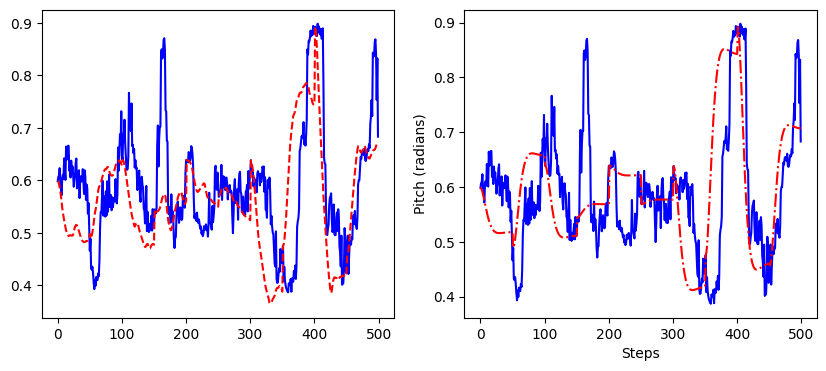

In [77]:
# tfrecord_file = "/app/ibc/data/gaze/evaluation/2d_L3ad5_data.tfrecord"
# # tfrecord_file = "/app/ibc/data/gaze/evaluation/mse_2d_L3ad5_data.tfrecord"

# step = next(_steps)
# raw_dataset = tf.data.TFRecordDataset(tfrecord_file)
# slice = raw_dataset.skip(step*49).take(49)

# x_coords = []
# y_coords = []

# for i in slice:
#    example = parse_example(i)
#    x,y = list(example['observation/fac_gaze_agent'].numpy())[2:]
#    x_coords.append(x)
#    y_coords.append(y)

# print(y_coords)

# # Load the CSV file and parse the first 50 rows
# # csv_file = "/app/output.csv"
# csv_file = "/app/all_concatenated_sessions.csv"
# df = pd.read_csv(csv_file)

# df = df[step*50:(step+1) * 50]

# # Drop the first row
# df = df.drop(df.index[-1])

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Create a plot
axs[0].plot(df['obs_fac_x'].to_list(), linestyle='-', color='b')  # Line plot with markers
axs[0].plot(x_coords_ebm, linestyle='--', color='r', label='vel_gaze_agent')
axs[1].plot(df['obs_fac_x'].to_list(), linestyle='-', color='b')  # Line plot with markers
axs[1].plot(x_coords_mse, linestyle='-.', color='r', label='vel_gaze_agent')
plt.xlabel('Steps')
plt.ylabel('Pitch (radians)')
# plt.title('Plot of Data Points')
# plt.grid(True)
plt.show()

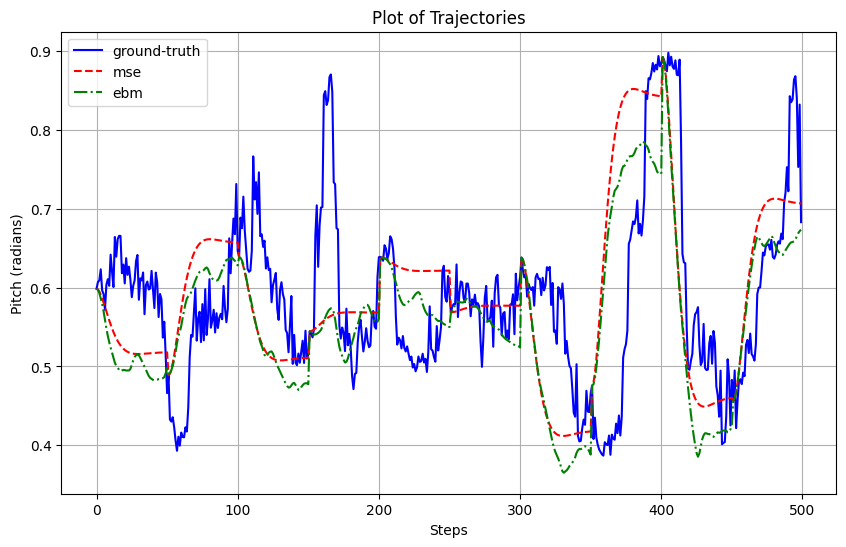

In [79]:
# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(df['obs_fac_x'].to_list(), linestyle='-', color='b', label='ground-truth')  # Line plot with markers
plt.plot(x_coords_mse, linestyle='--', color='r', label='mse')
plt.plot(x_coords_ebm, linestyle='-.', color='g', label='ebm')
plt.xlabel('Steps')
plt.ylabel('Pitch (radians)')
plt.title('Plot of Trajectories')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import torch
import pandas as pd
import os
import tensorflow as tf
from tf_agents.specs import tensor_spec
from tf_agents.utils import example_encoding
from tf_agents.utils import nest_utils
from tf_agents.trajectories import trajectory
from tf_agents.utils import example_encoding_dataset
from tf_agents.trajectories.time_step import StepType
import numpy as np
import csv

# Load the .pt file
actions = torch.load('/app/ibc/data/20220619_L3a-D5_l2cs/actions.pt')
observations = torch.load('/app/ibc/data/20220619_L3a-D5_l2cs/observations.pt')
target_motion = torch.load('/app/ibc/data/20220619_L3a-D5_l2cs/target_motion.pt')
targets = torch.load('/app/ibc/data/20220619_L3a-D5_l2cs/targets.pt')

# Convert the tensor to a NumPy array
actions_np = actions.numpy()
observations_np = observations.numpy()
targets_np = targets.numpy()

# Convert the NumPy array to a DataFrame
actions_df = pd.DataFrame(actions_np)
observations_df = pd.DataFrame(observations_np)
targets_df = pd.DataFrame(targets_np)

# Concatenate DataFrames
df = pd.concat([targets_df, actions_df, observations_df], axis=1)
print(df)

df.columns = ['target_x','target_y','velocity_x','velocity_y','obs_1_x','obs_1_y','obs_2_x','obs_2_y',
                'obs_3_x','obs_3_y','obs_4_x','obs_4_y','obs_5_x','obs_5_y','obs_fac_x','obs_fac_y']

# Save the DataFrame as a CSV file
df.to_csv('./app/output.csv', index=False) 

In [ ]:
val = df.iloc[-1]
len(df)

In [ ]:
import tensorflow as tf
from tf_agents.specs import tensor_spec
from tf_agents.utils import example_encoding
from tf_agents.utils import nest_utils
from tf_agents.trajectories import trajectory
from tf_agents.utils import example_encoding_dataset
from tf_agents.trajectories.time_step import StepType

file_path = './app/data.tfrecord'

def encode_step_type(step_type):
    # Convert StepType to an integer
    step_type_int = step_type.item()
    # Convert the integer to a 4-byte bytestring
    step_type_bytes = step_type_int.to_bytes(4, byteorder='little')  # Use 'big' or 'little' as needed

    # Create a TensorFlow tensor from the byte string
    # step_type_tensor = tf.convert_to_tensor(step_type_bytes, dtype=tf.string)
    return step_type_bytes

def get_step_type(index):
    if index in [0, 51]:
        return StepType.FIRST
    elif index == 50:  # Adjust this list as needed
        return StepType.LAST
    else:
        return StepType.MID

def create_example(step_type, observation, action, reward, discount, next_step_type, target):
    step_type_bytes = encode_step_type(step_type)
    next_step_type_bytes = encode_step_type(next_step_type)

    feature = {
        'step_type': tf.train.Feature(bytes_list=tf.train.BytesList(value=[step_type_bytes])),
        'observation/pos_first_goal': tf.train.Feature(float_list=tf.train.FloatList(value=target)),
        'observation/pos_agent': tf.train.Feature(float_list=tf.train.FloatList(value=observation)),
        'action': tf.train.Feature(float_list=tf.train.FloatList(value=action.numpy().tolist())),  # Convert tensor to list
        'reward': tf.train.Feature(float_list=tf.train.FloatList(value=[reward])),
        'next_step_type': tf.train.Feature(bytes_list=tf.train.BytesList(value=[next_step_type_bytes])),
        'discount': tf.train.Feature(float_list=tf.train.FloatList(value=[discount])),
    }

    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

with tf.io.TFRecordWriter(file_path) as writer:
    count = 0
    for index in range(len(actions)-1):
        serialized_example = create_example(
            step_type=get_step_type(count),
            observation=observations[index],
            action=actions[index],
            reward=0.0,
            next_step_type=get_step_type(count+1),
            discount=0.0,
            target=targets[index]
        )
        writer.write(serialized_example)
        count += 1
        if count > 50:
            count = 0

In [ ]:
from tf_agents.utils import example_encoding_dataset

# example_encoding_dataset.TFRecordObserver()
dataset_spec = example_encoding_dataset.parse_encoded_spec_from_file('/app/ibc/data/data/2d_oracle_particle.tfrecord.spec')
dataset_spec
# # {'action': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.7105392 , 0.50653803], dtype=float32)>, 'discount': <tf.Tensor: shape=(), dtype=float32, numpy=1.0>, 'next_step_type': <tf.Tensor: shape=(), dtype=string, numpy=b'\x01\x00\x00\x00'>, 'observation/pos_agent': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.70465255, 0.6553404 ], dtype=float32)>, 'observation/pos_first_goal': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.7105392 , 0.50653803], dtype=float32)>, 'observation/pos_second_goal': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.04481317, 0.9868854 ], dtype=float32)>, 'observation/vel_agent': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 0.], dtype=float32)>, 'reward': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'step_type': <tf.Tensor: shape=(), dtype=string, numpy=b'\x00\x00\x00\x00'>}
# # Trajectory(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), observation={'pos_agent': BoundedTensorSpec(shape=(2,), dtype=tf.float32, name='observation/pos_agent', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)), 'vel_agent': BoundedTensorSpec(shape=(2,), dtype=tf.float32, name='observation/vel_agent', minimum=array(-100., dtype=float32), maximum=array(100., dtype=float32)), 'pos_second_goal': BoundedTensorSpec(shape=(2,), dtype=tf.float32, name='observation/pos_second_goal', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)), 'pos_first_goal': BoundedTensorSpec(shape=(2,), dtype=tf.float32, name='observation/pos_first_goal', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32))}, action=BoundedTensorSpec(shape=(2,), dtype=tf.float32, name='action', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)), policy_info=(), next_step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)))


In [ ]:
from tf_agents.utils import example_encoding_dataset
from ibc.environments.gaze.gaze_oracles import GazeOracle
from tf_agents.environments import suite_gym

env_name = 'Gaze-v0'
dataset_path = '/app/ibc/spec_file.tfrecord'

env = suite_gym.load(env_name)

policy = GazeOracle(env)
example_encoding_dataset.TFRecordObserver(dataset_path,policy.collect_data_spec, py_mode=True,compress_image=True)


In [ ]:
# coding=utf-8
# Copyright 2024 The Reach ML Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Evaluates TF-Agents policies."""
import functools
import os
import shutil

from absl import app
from absl import flags
from absl import logging

import gin
# Need import to get env resgistration.
from ibc.environments.block_pushing import block_pushing  # pylint: disable=unused-import
from ibc.environments.block_pushing import block_pushing_discontinuous
from ibc.environments.block_pushing import block_pushing_multimodal
from ibc.environments.collect.utils import get_oracle as get_oracle_module
from ibc.environments.particle import particle  # pylint: disable=unused-import
from ibc.environments.gaze import gaze  # pylint: disable=unused-import
from ibc.environments.gaze import gaze_oracles
from ibc.environments.particle import particle_oracles
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import wrappers
from tf_agents.metrics import py_metrics
# Need import to get tensorflow_probability registration.
from tf_agents.policies import greedy_policy  # pylint: disable=unused-import
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_py_policy
from tf_agents.system import system_multiprocessing as multiprocessing
from tf_agents.utils import example_encoding_dataset

def evaluate(num_episodes,
             task,
             use_image_obs,
             shared_memory,
             flatten_env,
             saved_model_path=None,
             checkpoint_path=None,
             static_policy=None,
             dataset_path=None,
             history_length=None,
             video=False,
             viz_img=False,
             output_path=None):
  """Evaluates the given policy for n episodes."""
  if task in ['REACH', 'PUSH', 'INSERT', 'REACH_NORMALIZED', 'PUSH_NORMALIZED']:
    # Options are supported through flags to build_env_name, and different
    # registered envs.
    env_name = block_pushing.build_env_name(task, shared_memory, use_image_obs)
  elif task in ['PUSH_DISCONTINUOUS']:
    env_name = block_pushing_discontinuous.build_env_name(
        task, shared_memory, use_image_obs)
  elif task in ['PUSH_MULTIMODAL']:
    env_name = block_pushing_multimodal.build_env_name(
        task, shared_memory, use_image_obs)
  elif task == 'PARTICLE':
    # Options are supported through gin, registered env is the same.
    env_name = 'Particle-v0'
    assert not (shared_memory or use_image_obs)  # Not supported.
  elif task == 'GAZE':
    # Options are supported through gin, registered env is the same.
    env_name = 'Gaze-v0'
    assert not (shared_memory or use_image_obs)  # Not supported.
  else:
    raise ValueError("I don't recognize this task to eval.")

  if flatten_env:
    env = suite_gym.load(
        env_name, env_wrappers=[wrappers.FlattenObservationsWrapper])
  else:
    env = suite_gym.load(env_name)

  if history_length:
    env = wrappers.HistoryWrapper(
        env, history_length=history_length, tile_first_step_obs=True)

  if video:
    video_path = output_path

    if saved_model_path:
      policy_name = os.path.basename(os.path.normpath(saved_model_path))
      checkpoint_ref = checkpoint_path.split('_')[-1]
      video_path = os.path.join(video_path,
                                policy_name + '_' + checkpoint_ref + 'vid.mp4')

    if static_policy:
      video_path = os.path.join(video_path, static_policy, 'vid.mp4')


  if saved_model_path and static_policy:
    raise ValueError(
        'Only pass in either a `saved_model_path` or a `static_policy`.')

  if saved_model_path:
    if not checkpoint_path:
      raise ValueError('Must provide a `checkpoint_path` with a saved_model.')
    policy = py_tf_eager_policy.SavedModelPyTFEagerPolicy(
        saved_model_path, load_specs_from_pbtxt=True)
    policy.update_from_checkpoint(checkpoint_path)
  else:
    if static_policy == 'random':
      policy = random_py_policy.RandomPyPolicy(env.time_step_spec(),
                                               env.action_spec())
    elif task == 'PARTICLE':
      if static_policy == 'particle_green_then_blue':
        # TODO(peteflorence): support more particle oracle options.
        policy = particle_oracles.ParticleOracle(env)
      else:
        raise ValueError('Unknown policy for given task: %s: ' % static_policy)
    elif task == 'GAZE':
      policy = gaze_oracles.GazeOracle(env)
    elif task != 'PARTICLE':
      # Get an oracle.
      policy = get_oracle_module.get_oracle(env, flags.FLAGS.task)
    else:
      raise ValueError('Unknown policy: %s: ' % static_policy)

  metrics = [
      py_metrics.AverageReturnMetric(buffer_size=num_episodes),
      py_metrics.AverageEpisodeLengthMetric(buffer_size=num_episodes),
  ]
  env_metrics, success_metric = env.get_metrics(num_episodes)
  metrics += env_metrics

  observers = metrics[:]

  if viz_img and ('Particle' in env_name):
    visualization_dir = '/tmp/particle_oracle'
    shutil.rmtree(visualization_dir, ignore_errors=True)
    env.set_img_save_dir(visualization_dir)
    observers += [env.save_image]

  if dataset_path:
    # TODO(oars, peteflorence): Consider a custom observer to filter only
    # positive examples.
    observers.append(
        example_encoding_dataset.TFRecordObserver(
            dataset_path,
            policy.collect_data_spec,
            py_mode=True,
            compress_image=False))

  driver = py_driver.PyDriver(env, policy, observers, max_episodes=num_episodes)
  time_step = env.reset()
  initial_policy_state = policy.get_initial_state(1)
  driver.run(time_step, initial_policy_state)
  log = ['{0} = {1}'.format(m.name, m.result()) for m in metrics]
  logging.info('\n\t\t '.join(log))

  env.close()

In [ ]:
evaluate(
    num_episodes=200,
    task='GAZE',
    use_image_obs=False,
    shared_memory=False,
    flatten_env=False,
    saved_model_path=None,
    checkpoint_path=None,
    static_policy=None,
    dataset_path='ibc/data/particle/2d_oracle_particle.tfrecord',
    history_length=None,
    video=None,
    viz_img=None,
)